In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('..')

import pandas as pd
from tueplots import bundles
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from source.utils.charts import get_charts_by_region
from source.utils.regions import get_regional_weekly_charts_ranking, get_region_influence_ranking
from source.utils.visualization import plot_similarity_matrix
from source.utils.distance_functions import *

plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=1, usetex=True))
tqdm.pandas()

FEATURES_PATH = "../data/audio_features_processed.csv"
CHARTS_PATH = "../data/charts_processed.csv"
OUTPUT_PATH = '../data/'
CHARTS_V2_PATH = "../data/charts_processed_v2.csv"

In [2]:
def blocks(files, size=65536):
    while True:
        b = files.read(size)
        if not b: break
        yield b

# see if charts_v2 is available and print error if not
if not os.path.exists(CHARTS_V2_PATH):
    print("charts_v2.csv not found. Please run the script 'preprocessing_v2.ipynb' in 'exp' folder first.")
    exit(1)

num_lines = 0
with open(CHARTS_V2_PATH, "r",encoding="utf-8",errors='ignore') as f:
    num_lines = sum(bl.count("\n") for bl in blocks(f))
    
# Load the datasets into dataframes
with tqdm(total=int(num_lines)) as bar:
    charts_df = pd.read_csv(CHARTS_V2_PATH, parse_dates=['date'], date_format='%Y-%m-%d', skiprows=lambda x: bar.update(1) and False)
charts_df.head()

100%|██████████| 20321859/20321859 [01:26<00:00, 234766.35it/s]


,title,rank,date,artist,region,streams,track_id,streams_percentage
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,Argentina,253019.0,6mICuAdrwEjh6Y6lroV2Kg,0.032073
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,Argentina,223988.0,7DM4BPaS7uofFul3ywMe46,0.028393
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,Argentina,210943.0,3AEZUABDXNtecAOSC1qTfo,0.026739
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",Argentina,173865.0,6rQSrBHf7HlZjtcMZ4S4bO,0.022039
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,Argentina,153956.0,58IL315gMSTD37DOZPJ2hf,0.019516


In [3]:
# Load the audio features dataset
audio_df = pd.read_csv(FEATURES_PATH)

# Change the column-name of 'id' to 'track_id' to match the charts_df
audio_df.rename(columns={'id': 'track_id'}, inplace=True)
audio_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_id
0,0.18700,0.852,195840,0.773,0.000030,8,0.1590,-2.921,0,0.0776,102.034,4,0.907,6mICuAdrwEjh6Y6lroV2Kg
1,0.00431,0.663,259196,0.920,0.000017,11,0.1010,-4.070,0,0.2260,99.935,4,0.533,7DM4BPaS7uofFul3ywMe46
2,0.40000,0.761,222560,0.838,0.000000,4,0.1760,-3.073,0,0.0502,93.974,4,0.710,3AEZUABDXNtecAOSC1qTfo
3,0.55100,0.508,205600,0.687,0.000003,0,0.1260,-4.361,1,0.3260,180.044,4,0.555,6rQSrBHf7HlZjtcMZ4S4bO
4,0.07600,0.899,234320,0.626,0.000000,6,0.0631,-4.228,0,0.2920,88.007,4,0.873,58IL315gMSTD37DOZPJ2hf


In [4]:
# Drop all the tracks that are not in the features dataset
# first check how many tracks are in the charts_df but not in the audio_df
print("Number of tracks in charts_df but not in audio_df: ", len(charts_df[~charts_df["track_id"].isin(audio_df["track_id"])]))
charts_df = charts_df[charts_df["track_id"].isin(audio_df["track_id"])]

Number of tracks in charts_df but not in audio_df:  0


In [5]:
full_data = 365 * 5 * 200
full_data # the amount of data that I expect for 5 years of daily chart results with 200 ranks

365000

In [6]:
# integrity ratio by region

region_data_volume = np.round(charts_df['region'].value_counts() * 100 / full_data, 1)
region_data_volume

region
Brazil           99.9
Argentina        99.8
United States    99.8
Austria          99.7
Australia        99.2
                 ... 
Russia           27.6
Ukraine          27.6
Bulgaria         26.0
South Korea      16.3
Luxembourg        2.5
Name: count, Length: 69, dtype: float64

In [7]:
complete_regions = region_data_volume[region_data_volume >= 95].index.to_list()
complete_regions.remove('Global')
complete_regions

['Brazil',
 'Argentina',
 'United States',
 'Austria',
 'Australia',
 'Canada',
 'United Kingdom',
 'Switzerland',
 'France',
 'Philippines',
 'Malaysia',
 'Belgium',
 'Ireland',
 'Indonesia',
 'Hong Kong',
 'Singapore',
 'Denmark',
 'Sweden',
 'New Zealand',
 'Ecuador',
 'Colombia',
 'Costa Rica',
 'Italy',
 'Spain',
 'Mexico',
 'Finland',
 'Turkey',
 'Taiwan',
 'Chile',
 'Norway',
 'Peru',
 'Poland',
 'Netherlands',
 'Portugal',
 'Germany',
 'Czech Republic',
 'Japan',
 'Guatemala',
 'Uruguay']

In [8]:
# An example of getting monthly charts for Turkey
turkey_df = get_charts_by_region(charts_df, 'Turkey')
turkey_df.head()

,title,rank,date,artist,region,streams,track_id,streams_percentage
7844,Gece Gölgenin Rahatına Bak,1,2017-01-01,Çağatay Akman,Turkey,80607.0,3P31rcl0ym5paqRdwSiZps,0.051221
7845,Starboy,2,2017-01-01,"The Weeknd, Daft Punk",Turkey,44427.0,5aAx2yezTd8zXrkmtKl66Z,0.028231
7846,Affet,3,2017-01-01,Müslüm Gürses,Turkey,34889.0,0ikRchpmFlaqlzLRgu9qWk,0.022170
7847,Rockabye (feat. Sean Paul & Anne-Marie),4,2017-01-01,Clean Bandit,Turkey,28400.0,5knuzwU65gJK7IF5yJsuaW,0.018046
7848,Let Me Love You,5,2017-01-01,"DJ Snake, Justin Bieber",Turkey,25425.0,4pdPtRcBmOSQDlJ3Fk945m,0.016156


In [9]:

turkey_weekly = get_regional_weekly_charts_ranking(turkey_df, ("1-1-2018", "1-30-2018"), normalize_streams=False)

In [10]:
turkey_weekly.head()

,index,track_id,streams,rank,title,artist,region,start_date,end_date
0,80,2BJkinM7TmdcsDGNvmZds8,2475718.0,1,Yanıyoruz,Burak King,Turkey,1-1-2018,1-30-2018
30,184,4sa0pXDdQkBZ1r5NZWQJyV,2033558.0,2,Heyecanı Yok,Gazapizm,Turkey,1-1-2018,1-30-2018
60,209,5dLtu0lS5pP9ivMerk3uMA,1686875.0,3,Gömün Beni Çukura,Eypio,Turkey,1-1-2018,1-30-2018
90,282,7wGoVu4Dady5GV0Sv4UIsx,1589483.0,4,rockstar,"Post Malone, 21 Savage",Turkey,1-1-2018,1-30-2018
120,203,5Y3ZTBwRNrgj3AlXYASvDe,1489374.0,5,İmkansızım,Ezhel,Turkey,1-1-2018,1-30-2018


In [11]:
len(turkey_weekly["track_id"])

283

In [12]:
# test the distance functions
test_get_distance_kendalltau()
test_kendall_tau_dist()

In [13]:
complete_regions_df = get_charts_by_region(charts_df, complete_regions)
print("Started calculating")
similarity_matrix, region_array, dates, info_dict = get_similarity_matrix(complete_regions_df, complete_regions, 
                                                          "1-1-2017", "30-11-2021", "weekly", similarity_function = get_similarity_linear_combination(0.8, 0.2),
                                                          similarity_function_name="linear_combination_0.8_0.2")

Started calculating


Calculating similarity matrix for weekly mode using linear_combination_0.8_0.2 similarity function: 100%|██████████| 4/4 [02:48<00:00, 42.09s/it]


In [15]:
# get the region influence ranking
region_influence_df = get_region_influence_ranking(similarity_matrix, region_array)
print(region_influence_df)

            region  influence
0      Switzerland  16.039156
1   Czech Republic  15.969429
2           Poland  15.673835
3          Belgium  15.600500
4        Singapore  15.541989
5      New Zealand  14.902928
6         Portugal  14.883637
7        Australia  14.722819
8          Ireland  14.574012
9          Austria  14.554809
10        Malaysia  14.334905
11       Guatemala  14.329968
12          Canada  14.212742
13         Ecuador  13.928046
14       Indonesia  13.924362
15      Costa Rica  13.911691
16          Norway  13.876276
17          Sweden  13.765319
18         Germany  13.741816
19           Spain  13.603332
20  United Kingdom  13.484461
21           Italy  13.444378
22        Colombia  13.244064
23     Netherlands  13.116767
24         Denmark  13.040828
25       Hong Kong  13.017890
26          Mexico  12.993542
27          Turkey  12.962940
28   United States  12.925232
29            Peru  12.831163
30     Philippines  12.684948
31          Taiwan  12.586332
32        

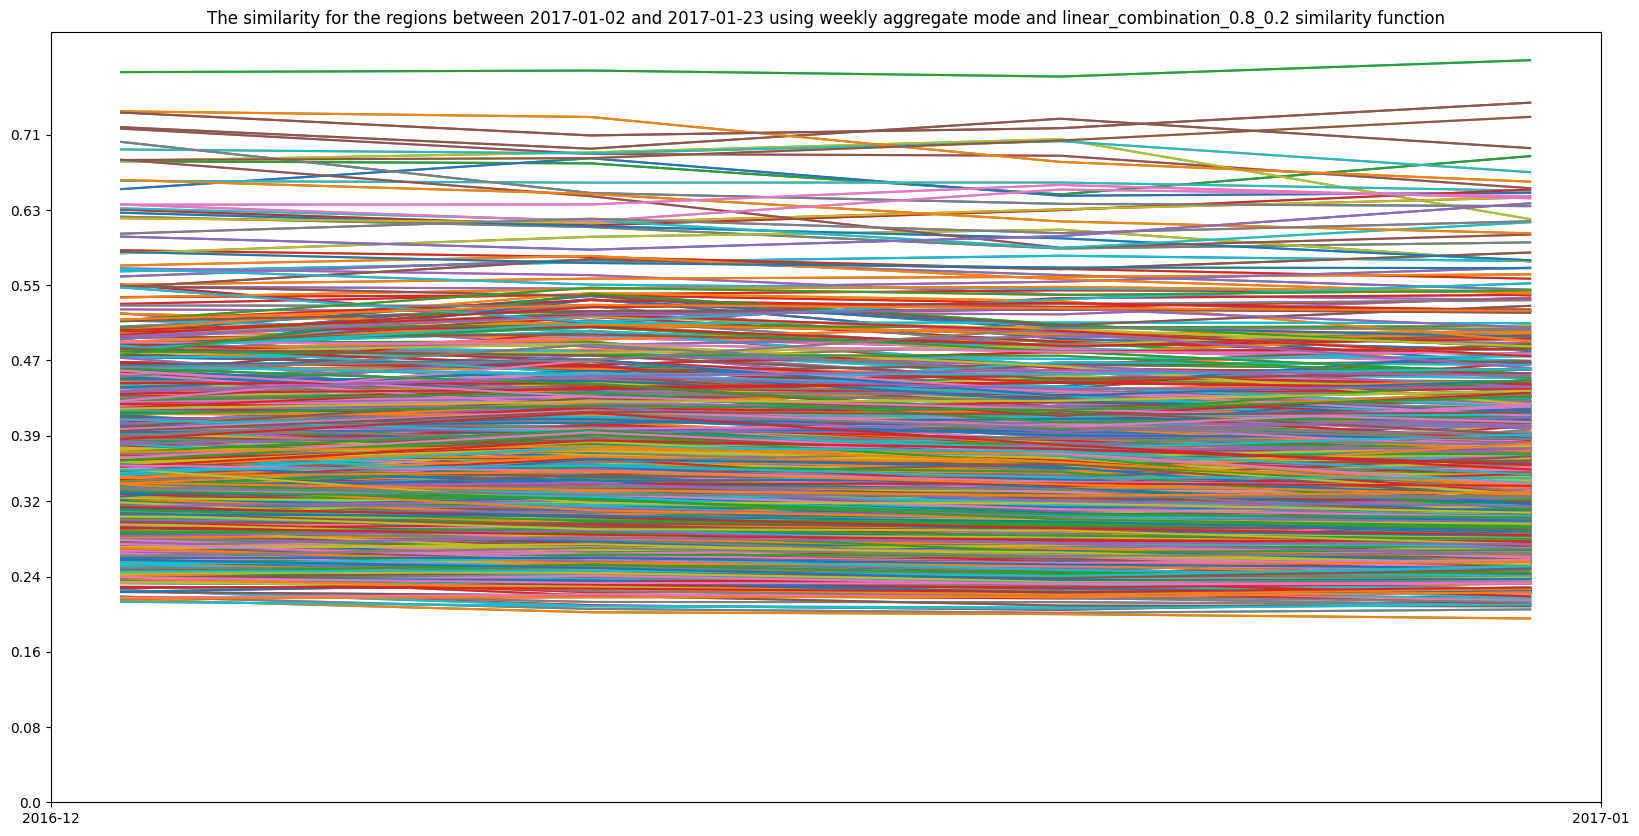

In [16]:
plot_similarity_matrix(similarity_matrix, dates, info_dict, region_array)

In [17]:
# add all outputs to an object and save it with a meaningful name
output = {"similarity_matrix": similarity_matrix, "region_array": region_array, "dates": dates, "info_dict": info_dict, "region_influence_df": region_influence_df}
np.save(os.path.join(OUTPUT_PATH, "region_influence_dict_08_02.npy"), output)